## Stock selection according to Hossein PTS Cointegration 
- we calculate the spread between the normalized prices of all possible combinations of stock pairs during the formation period. The formation period is chosen to be 12 months. 
- The normalized price is defined as the cumulative return index, adjusted for dividends and other corporate actions, and scaled to $1 at the beginning of the formation period. In the trading period, this price is used to calculate the spread. 
- We then select 20 of those combinations that have the least sum of squared spreads, or sum of squared differences (SSD), to form the nominated pairs to trade in the following trading period, that is chosen to be 6 months. The standard deviation of the spread during the formation period is also recorded and used as the trading criterion. A specific stock can participate in forming more than one pair as long as the other stock of the pair varies.
- then we test each of the pairs with the least SSD for cointegration,
by using their cumulative return series in the formation period. Pairs that are not cointegrated are eliminated in the selection process. Pairs that are cointegrated will have their cointegration coefficient estimated. We continue until 20 cointegrated pairs with minimum SSDs are selected to be traded in the following trading period
- After selecting nominated cointegrated pairs using the two-step Engle-Granger method (Engle and Granger, 1987), we extract their stationary spread.
- Thus, the profit of buying one share of stock 2 and selling beta share of stock 1 for the period delta t is given by the change in the spread for that period.

In [ ]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
import math 
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
from cointegration_functions import * 

def run_strategy_hossein(stocks: pd.DataFrame):
    stocks.index = pd.to_datetime(stocks.index)
    time_frame = stocks.index

    months = pd.Series(time_frame).dt.to_period('M').unique()  # Extract unique months

    # This is the main dataframe, that stores the daily returns of each portfolio 
    returns_dictionary = {}

    n_trading_periods = 0 

    # Iterate through months instead of days
    for start_idx in range(len(months)):

        formation_start = pd.Timestamp(months[start_idx].start_time)
        formation_end = formation_start + pd.DateOffset(months=24)-pd.DateOffset(days=1)  # 24 months later
        trading_start = formation_start + pd.DateOffset(months=24)
        trading_end = formation_end + pd.DateOffset(months=6)  # Next 6 months
        
        # Ensure we don't exceed the timeframe
        if trading_end > time_frame[-1]:
            break
        
        # The backtest algorithm starts here:
        # 1. normalize the stock data at the start of the formation period to 1$  
        stocks_normalized = normalize(stocks.loc[formation_start:trading_end])

        # Select formation period data   
        stocks_formation = stocks_normalized.loc[formation_start:formation_end]
        # Select testing data (next 6 months)
        stocks_trading = stocks_normalized.loc[trading_start:trading_end]
        
        # Formation part 
        # 2. sort by ssd ~ 1 minute
        print("\nSorting all combinations by SSD...\n")
        print("=" * 80)
        pairs_sorted = calculate_and_sort_ssd(stocks_formation)

        print(f"Formation Start:\n{stocks_formation.index[0]}")
        print("X" * 80)

        # 3. Select 20 cointegrated pairs 
        print("\nSelecting cointegrated pairs using Engle-Kranger method...\n")
        print("=" * 80)
        portfolio = select_cointegrated_pairs(stocks_formation, pairs_sorted)

        print(f"Formation End:\n{stocks_formation.index[-1]}")
        print("-" * 80)

        print(f"Trading Start:\n{stocks_trading.index[0]}")
        
        # Trading part 
        # 4. Calculate spread and normalized spread for all 20 pairs of the portfolio
        print("\nCalculating spread in the trading period...\n")
        print("=" * 80)
        spread_df, spread_df_norm = calculate_portfolio_spread(stocks_trading, portfolio)

        # 5. Trade portfolio
        print("\nPortfolio is trading...\n")
        print("=" * 80)
        result_df = trade_portfolio(spread_df, spread_df_norm)

        print(f"Trading End:\n{stocks_trading.index[-1]}\n")
        print("X" * 80)

        # 6. Calculate daily returns of each portfolio and append this column for each trading period
        # calculated as a row sums of the daily returns of 20 pairs 
        returns_dictionary[f"Portfolio_{trading_start}"] = result_df.sum(axis=1)
        n_trading_periods += 1
        print("Number of trading periods: ", n_trading_periods) 

    return pd.DataFrame(returns_dictionary)

In [ ]:
#stocks_1990_2025 = pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/stocks_1990_2025.csv", index_col = 0)
#backtest_result_1990_2025 = run_strategy_hossein(stocks_1990_2025)
#backtest_result_1990_2025.to_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/test_files/backtestfrom1990to2025_correct_result.csv")

118.12041281376072
(8309, 391)


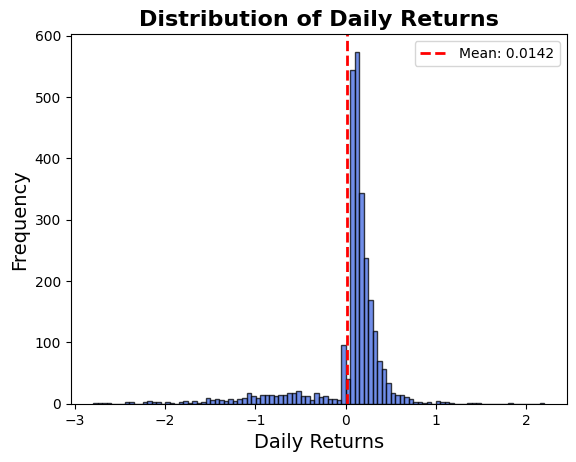

In [ ]:
backtest_result_1990_2025=pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/test_files/backtestfrom1990to2025_correct_result.csv", index_col = 0)

# Daily returns of the 6 overlapping portfolios for the selected time frame. 
daily_returns = pd.DataFrame(backtest_result_1990_2025).sum(axis=1)
daily_returns_hist = daily_returns[daily_returns !=0]

print(sum(daily_returns))
print(backtest_result_1990_2025.shape)
plt.hist(daily_returns_hist, bins=100, color="royalblue", edgecolor="black", alpha=0.75)

# Labels and title
plt.xlabel("Daily Returns", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Daily Returns", fontsize=16, fontweight="bold")
plt.axvline(daily_returns.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {daily_returns.mean():.4f}")
plt.legend()

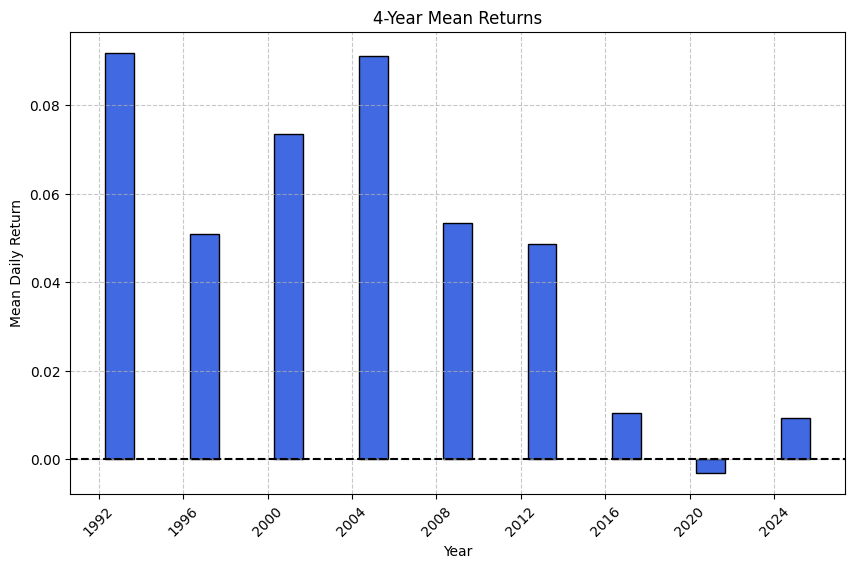

In [ ]:
daily_returns_hist = daily_returns_hist[daily_returns_hist.index < "2025-01-01"]
daily_returns_hist.index = pd.to_datetime(daily_returns_hist.index)
yearly_returns = daily_returns_hist.resample("4YE").mean()

# Bar plot of 4-year mean returns
plt.figure(figsize=(10, 6))  # Adjust figure size for better clarity
plt.bar(yearly_returns.index - pd.DateOffset(years=0), yearly_returns.values, width = 500, color='royalblue', edgecolor='black', label='4-Year Mean Return')
plt.axhline(0, color='black', linestyle='--')  # Reference line at 0
plt.xlabel("Year")
plt.ylabel("Mean Daily Return")
plt.title("4-Year Mean Returns")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.show()